In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Accuracy
from mpl_toolkits import mplot3d
from matplotlib.animation import FuncAnimation # To visualize in animation
from IPython import display # To display in html
from matplotlib import rc
rc('text', usetex=True)

In [2]:
import os
current = os.getcwd()
print(current)

C:\Users\admin\Lab_training\Week9_10


# Multi Layer Perceptron

**(mini-batch)**
For each batch
## Step 1: Feed forward:
$\textbf{Z}^{(1)} = \textbf{X.W}^{(1)}+\textbf{B}^{(1)}$

$\textbf{Z}^{(l+1)} = \textbf{A}^{(l)}.\textbf{W}^{(l+1)}+\textbf{B}^{(l+1)}$

$\textbf{A}^{(l)} = f(\textbf{Z}^{(l)})$

## Step 2: Back propagation: 
$\textbf{E}^{(L)} = \nabla_{\textbf{Z}^{(L)}} J$

$\nabla_{\textbf{W}^{(l+1)}}J = \textbf{A}^{(l)T}.\textbf{E}^{(l+1)}$

$\nabla_{\textbf{b}^{(l+1)}}J = \sum_{k=1}^{N}{\textbf{e}_{k}^{(l+1)}}$

$\textbf{E}^{(l)} = \textbf{E}^{(l+1)}.\textbf{W}^{(l+1)T} \odot f'(\textbf{Z}^{(l)})$

## Step 3: Gradient Descent:
$\textbf{W}^{(l)} \leftarrow \textbf{W}^{(l)} - \eta \nabla_{\textbf{W}^{(l)}}J$

$\textbf{b}^{(l)} \leftarrow \textbf{b}^{(l)} - \eta \nabla_{\textbf{b}^{(l)}}J$




**Remember**: $\textbf{X, A, Z}$ always have the head size is N: batch_size. It's convenient to do in programming.


**Weight Decay**
$L = J + \frac{\lambda}{2}\sum_{l=1}^{L} ||\textbf{W}^{(l)}||_{F}^{2}$

## Softmax with a hidden layer.

<img src="ex_nn.png"/>

In [3]:
def softmax(z):
    return torch.exp(z)/torch.exp(z).sum(keepdims = True, dim = 1)

def softmax_stable(z):
    return softmax(z-torch.max(z, keepdims = True, dim = 1)[0])

In [4]:
def CrossEntropyLoss(Y_hat, Y):
    N = Y.shape[0]
    return -1/N*torch.sum(Y*torch.log(Y_hat)).item()

def mlp_init(d, d1):
    W = torch.randn(d, d1)
    b = torch.zeros(d1)
    return [W, b]

In [5]:
def ReLU(z):
    z_ = z.clone()
    z_[z<=0] = 0
    return z_

In [6]:
Layers = []
def Linear(d, d1):
    global Layers
    Layers.append((d,d1))
    return linear
def linear(W,b,X):
    return X.mm(W)+b

In [7]:
class MyNet():
    """
    Defalut: Softmax in: 2, out: 5
    """
    global Layers
    Layers = []
    def __init__(self):
        self.linear_relu_stack = [
            Linear(2, 200),
            ReLU,
            Linear(200, 100),
            ReLU,
            Linear(100, 5),
            softmax_stable
        ]
        self.weights = self.init()
        self.Z = [0 for _ in range(len(self.weights))]
        self.A = [0 for _ in range(len(self.weights))]
        
    def init(self):
        weights = []
        for i in range(len(Layers)):
            weights.append(mlp_init(*Layers[i]))
        return weights
    
    def add(self, x):
        self.linear_relu_stack.append(x)
        
    def Sequential(self, x):
        self.linear_relu_stack = x
        
    def forward(self, X):
        for i, func in enumerate(self.linear_relu_stack):
            try:
                if i//2-1 < 0:
                    Z = func(self.weights[i//2][0], self.weights[i//2][1], X)
                else:        
                    Z = func(self.weights[i//2][0], self.weights[i//2][1], self.A[i//2-1])
                self.Z[i//2] = Z
            except TypeError:
                A = func(self.Z[i//2])
                self.A[i//2] = A
        return self.A[-1]
            
    def backward(self, X, Y, lr):
        E = [0 for _ in range(len(self.A))]
        g = [0 for _ in range(len(self.A))]
        # batch_size
        N = self.Z[0].shape[0]
        for i in range(1,len(E)+1):
            if i == 1:
                E[-i] = 1/N*(self.A[-i] - Y) # softmax
            else:
                E[-i] = E[-i+1].mm(self.weights[-i+1][0].T) # relu
                E[-i][self.Z[-i]<=0] = 0
            if i < len(E):
                dw = self.A[-i-1].T.mm(E[-i])
            else:
                dw = X.T.mm(E[-i])
            db = E[-i].sum(dim = 0)
            g[-i] = (dw, db)
        
        # Gradient descent
        for i in range(len(g)):
            self.weights[i][0] += -lr*g[i][0]
            self.weights[i][1] += -lr*g[i][1]
            
    def fit(self, X, Y, lr = 0.01, tol = 1e-3, epochs = 500, batch_size = 64, loss_fn = nn.NLLLoss()):
        N, d = X.shape
        it = 0
        loss_hist = []
        for epoch in range(epochs):
            # shuffle data
            rd_ids = torch.randperm(N)
            for i in range(0, N, batch_size):
                indices = rd_ids[i:min(i+batch_size,N)]
                features = X[indices]
                labels = Y[indices]
                # Compute prediction error
                pred = net.forward(features)
                loss = loss_fn(Y_hat = pred, Y = labels)
                loss_hist.append(loss)
                if loss<tol:
                    return loss_hist, it, epoch
                # Backpropagagion
                net.backward(features, labels, lr = lr)
                it=+1
        return loss_hist, it, epoch
    
    def predict(self, X):
        A = self.forward(X)
        return torch.argmax(A, dim = 1)

In [8]:
C, N = 5, 500 # number of classes and number of points per class
means = [[2, 2], [8, 3], [3, 6], [14, 2], [12, 8]]
cov = [[1, 0], [0, 1]]
np.random.seed(2)
X0 = torch.Tensor(np.random.multivariate_normal(means[0], cov, N))
X1 = torch.Tensor(np.random.multivariate_normal(means[1], cov, N))
X2 = torch.Tensor(np.random.multivariate_normal(means[2], cov, N))
X3 = torch.Tensor(np.random.multivariate_normal(means[3], cov, N))
X4 = torch.Tensor(np.random.multivariate_normal(means[4], cov, N))
X = torch.cat((X0, X1, X2, X3, X4), dim = 0).type(torch.float32) # each row is a datapoint
Xbar = torch.cat((X, torch.ones((X.shape[0], 1))), dim = 1) # bias trick
y = torch.asarray([0]*N + [1]*N + [2]*N+ [3]*N + [4]*N).reshape(-1,1) # label
Y = F.one_hot(y, num_classes = 5).squeeze() # onehot

In [9]:
net = MyNet()
loss_hist, it, ep = net.fit(X, Y, epochs = 100, loss_fn = CrossEntropyLoss, batch_size = 10)

C:\Users\admin\miniconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


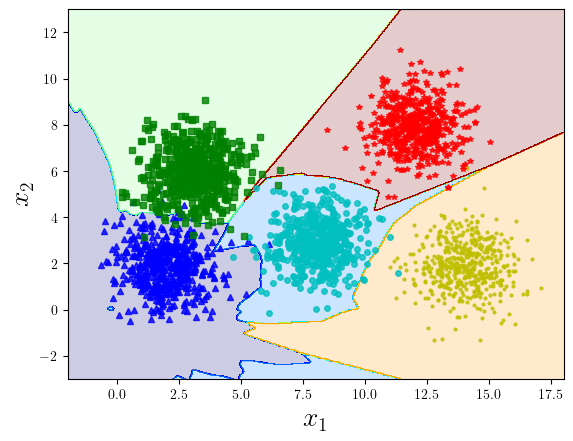

In [10]:
plt.plot(X0[:, 0], X0[:, 1], 'b^', markersize = 4, alpha = .8)
plt.plot(X1[:, 0], X1[:, 1], 'co', markersize = 4, alpha = .8)
plt.plot(X2[:, 0], X2[:, 1], 'gs', markersize = 4, alpha = .8)
plt.plot(X3[:, 0], X3[:, 1], 'y.', markersize = 4, alpha = .8)
plt.plot(X4[:, 0], X4[:, 1], 'r*', markersize = 4, alpha = .8)
xx = torch.linspace(-2,18,500)
yy = torch.linspace(-3,13,500)
XX, YY = torch.meshgrid(xx, yy)
xx1 = XX.flatten().reshape(-1,1)
yy1 = YY.flatten().reshape(-1,1)

XX1 = torch.cat((xx1, yy1), dim = 1)

Z = net.predict(XX1)
plt.contourf(XX,YY,Z.reshape(XX.shape), 200, cmap = 'jet', alpha = 0.2)

plt.xlabel('$x_1$', fontsize = 20)
plt.ylabel('$x_2$', fontsize = 20)
plt.savefig('ForLatex\mlp_softmax_1.pdf', bbox_inches = 'tight')

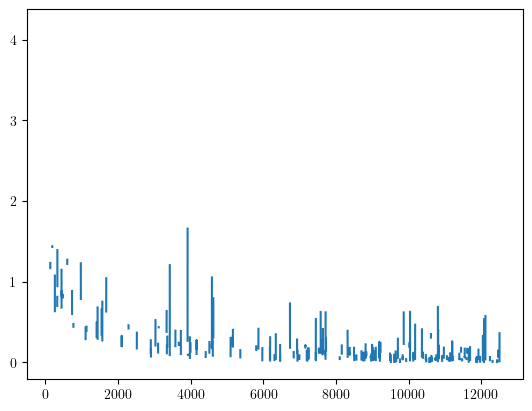

In [11]:
plt.plot(loss_hist)